# Overview of the WildlifeReID-10k dataset

This notebook show a basic analysis of the [WildlifeReID-10k](https://www.kaggle.com/datasets/wildlifedatasets/wildlifereid-10k) dataset. We first analyze the dataset and then show to evaluate an already trained model. We first import the required packages.

In [3]:
import os
import copy
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from wildlife_datasets import datasets, splits
# from utils_wildlifereid10k.utils_wildlifereid10k import *

Now we load the dataset. It is possibly to use directly `datasets.WildlifeReID10k(root)` and then access `df = d.df`. This would perform additional checks about the correctness of the dataset. However, since one of the check is very slow on Kaggle, we load the dataset manually.

In [4]:
root = '/wildlife-datasets-main/data/BirdIndividualID_small/'
df = pd.read_csv(root + '/metadata.csv').reset_index()
df['date'] = pd.to_datetime(df['date'])
d = datasets.WildlifeReID10k(root, df)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/wildlifereid-10k/metadata.csv'

We show the dataframe `df`. It consists of 214,262 images, where each depicts an individual animal. As we will see later, there are 10,343 individual animals.

In [4]:
df

,index,identity,path,date,orientation,species,dataset,split
0,0,AAUZebraFish_5,images/AAUZebraFish/data/Vid2_0520_0000ef3f3f3...,NaT,right,fish,AAUZebraFish,train
1,1,AAUZebraFish_5,images/AAUZebraFish/data/Vid2_0018_00024452851...,NaT,left,fish,AAUZebraFish,train
2,2,AAUZebraFish_3,images/AAUZebraFish/data/Vid1_0062_0002c4ff6de...,NaT,right,fish,AAUZebraFish,train
3,3,AAUZebraFish_4,images/AAUZebraFish/data/Vid2_1065_000444965a5...,NaT,right,fish,AAUZebraFish,train
4,4,AAUZebraFish_3,images/AAUZebraFish/data/Vid1_0851_000e4b1f6c1...,NaT,left,fish,AAUZebraFish,train
...,...,...,...,...,...,...,...,...
214257,214257,ZindiTurtleRecall_t_id_ip3jsrYo,images/ZindiTurtleRecall/images/ID_ZYTRP3VN_ID...,NaT,left,sea turtle,ZindiTurtleRecall,train
214258,214258,ZindiTurtleRecall_t_id_o8HFaaCp,images/ZindiTurtleRecall/images/ID_ZZ04P34G_ID...,NaT,NaN,sea turtle,ZindiTurtleRecall,test
214259,214259,ZindiTurtleRecall_t_id_ruF8Nbxs,images/ZindiTurtleRecall/images/ID_ZZD2VBPA_ID...,NaT,NaN,sea turtle,ZindiTurtleRecall,train
214260,214260,ZindiTurtleRecall_t_id_m2JvEcsg,images/ZindiTurtleRecall/images/ID_ZZEGHRM5_ID...,NaT,left,sea turtle,ZindiTurtleRecall,train


We plot a 3*4 sample of the dataset. It is clear that the depicted species, the image quality and the time conditions are extremely different for all images. The sample contains three underwater photos and one night photo.

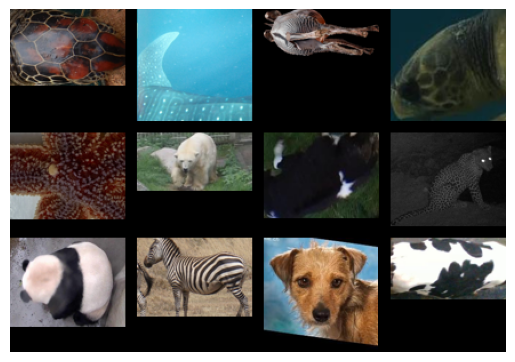

In [5]:
d.plot_grid(n_rows=3, n_cols=4, idx=np.arange(0, len(df), 10000)[::-1]);

We show summary of the incorporated species. The majority of species are wild and domestic species are in minority.

In [6]:
get_summary_species(df)

,images,individuals
bird,52274,50
cat,13021,509
chimpanzee,6771,95
cow,20724,375
dog,10020,1584
doplhin,2657,82
fish,6672,6
giraffe,2032,329
hyena,3129,256
leopard,6806,430


## Splits for algorithm training

WildlifeReID-10k contains a default split. The split is open-set, meaning that some animals are only in the testing set but not in the training set. For such animals, the algorithm should predict that they are new. The evaluation is possible for both the open-set and closed-set, where for the latter the individuals only in the testing set are ignored. The following summary shows that the training set consists of 78.75% images, the new individuals 11.22% and the known individuals the remaining 10.02%. In other words, the open-set problem will be evaluated at 21.25% of the dataset, while the closed-set only at 10.02% of the dataset.

In [7]:
idx_train = np.where(df['split'] == 'train')[0]
idx_test = np.where(df['split'] == 'test')[0]
splits.analyze_split(df, idx_train, idx_test)

Split: time-unaware open-set
Samples: train/test/unassigned/total = 168739/45523/0/214262
Classes: train/test/unassigned/total = 9437/9403/0/10344
Samples: train only/test only        = 941/24031
Classes: train only/test only/joint  = 941/907/8496

Fraction of train set     = 78.75%
Fraction of test set only = 11.22%


We can indeed verify that there are 907 individuals which are in the testing set only.

In [8]:
identity = df['identity'].to_numpy()
identity_train = identity[df['split'] == 'train']
identity_test = identity[df['split'] == 'test']
identity_test_only = list(set(identity_test) - set(identity_train))
len(identity_test_only)

907

## Evaluation of trained algorithms

We assume that the user has already trained some of his algorithm on the training set. We have used [MegaDescriptor](https://www.kaggle.com/datasets/wildlifedatasets/wildlifereid-10k-features) to extract features. We load them and observe that there are 214,262 features vectors (the same number as images), each of length 1,536.

In [9]:
features = torch.load('/kaggle/input/wildlifereid-10k-features/WildlifeReID-10k_features.pth')
features.shape

(214262, 1536)

We select the SeaTurtleID2022 dataset and the corresponding features for the training and testing sets.

In [10]:
dataset = 'SeaTurtleID2022'

df_dataset = df[df['dataset'] == dataset]
df_train = df[(df['dataset'] == dataset) * (df['split'] == 'train')]
df_test = df[(df['dataset'] == dataset) * (df['split'] == 'test')]
features_train = features[df_train.index]
features_test = features[df_test.index]

We make predictions based on 1-NN in the feature space. The used method `compute_predictions` uses cosine similarity to measure distance between the feature vectors. For each testing image, we return `k=5` closest predictions from the training set.

In [11]:
idx_true, idx_pred, score = compute_predictions(features_test, features_train, k=5, return_similarity=True)
identity_true = identity[df_test.index.to_numpy()[idx_true]]
identity_pred = identity[df_train.index.to_numpy()[idx_pred]]

Since we never predict new individuals, we want to remove the identities which are in the testing set only. The balanced accuracy equals to 80.29%.

In [12]:
idx = ~np.isin(identity_true, identity_test_only)
balanced_accuracy_score(identity_true[idx], identity_pred[idx][:,0])

0.8029398418048588

We can obtain the same results by using the in-build functions `BAKS` (balanced accuracy on known samples) and `BAUS` (balanced accuracy on unknown samples). Since we never predicted new individuals, `baus` is necessarily zero.

In [13]:
new_individual = 'new_individual'

baks = metrics.BAKS(identity_true, identity_pred[:,0], identity_test_only)
baus = metrics.BAUS(identity_true, identity_pred[:,0], identity_test_only, new_class=new_individual)

baks, baus

(0.8029398418048574, 0.0)

Our prediction algoritms also returns the similarity score for the closest match. We can use it and predict a new individual whenever this score is below a certain threshold. We use increasing values of `t`, where small values of `t` mean that the majority of images will be classified as new individuals, while large values of `t` mean that the majority of images will be classified as known individuals.

Text(0.5, 1.0, 'SeaTurtleID2022')

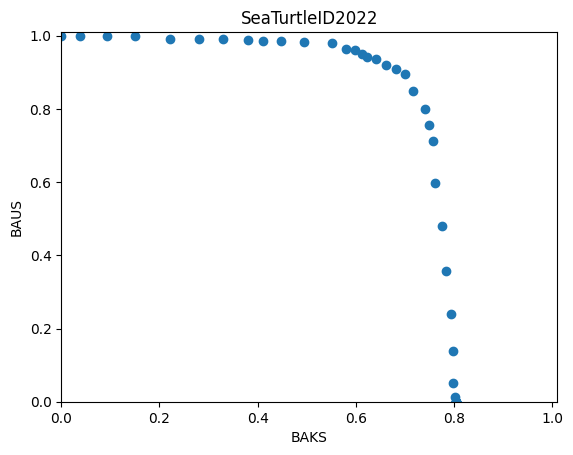

In [14]:
baks_all = []
baus_all = []
for t in np.linspace(0, 1, 41):
    identity_pred_new = copy.copy(identity_pred)
    identity_pred_new[score <= t] = new_individual

    baks = metrics.BAKS(identity_true, identity_pred_new[:,0], identity_test_only)
    baus = metrics.BAUS(identity_true, identity_pred_new[:,0], identity_test_only, new_class=new_individual)
    baks_all.append(baks)
    baus_all.append(baus)

plt.scatter(baks_all, baus_all)
plt.xlabel('BAKS')
plt.ylabel('BAUS')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.title(dataset)

## Baseline performance

In the accompanying paper, we proposed the metrics BAKS and BAUS were averaged over all datasets. We therefore first compute them in the closed-set setting and in the open-set settings. When checking the functions `predict`, it becomes clear that we compared features only within the same dataset. We believe that this is fine because dataset curator usually know which species images depict and they are interested in recognizing the individual. In other words, they are not interested in matching sea turtles with zebras.

In [15]:
y_pred_closed, similarity_pred = predict(df, features)

Then we compute the balanced accuracy on the closed-set setting and both balanced accuracies on the open-set setting.

In [16]:
baks_closed, _ = compute_baks_baus(df, y_pred_closed, new_individual=new_individual)
y_pred_open = copy.copy(y_pred_closed)
with np.errstate(invalid='ignore'):
    y_pred_open[similarity_pred <= 0.8] = new_individual
baks_open, baus_open = compute_baks_baus(df, y_pred_open, new_individual=new_individual)
results = pd.DataFrame({
    'BAKS closed': baks_closed,
    'BAKS open': baks_open,
    'BAUS open': baus_open,
})
results

,BAKS closed,BAKS open,BAUS open
AAUZebraFish,1.000000,1.000000,0.242173
ATRW,0.985631,0.942057,0.682882
AerialCattle2017,1.000000,1.000000,0.721271
BelugaID,0.822910,0.677464,0.981887
BirdIndividualID,0.970926,0.967770,0.377669
CTai,0.788700,0.638254,0.771616
CZoo,0.987906,0.958485,0.429304
CatIndividualImages,0.923164,0.833098,0.833757
CowDataset,0.987013,0.987013,0.692899
Cows2021,1.000000,0.990683,0.950202


Finally, we extract the final metrics for both settings. They are 87.09% and 74.08% for the closed-set and open-set setting, respectively. Now it is your time to beat us :)

In [17]:
metric_closed = results['BAKS closed'].mean()
metric_open = 0.5*(results['BAKS open'].mean() + results['BAUS open'].mean())
metric_closed, metric_open

(0.8708935182554183, 0.7408286613565638)